In [7]:
import sys
sys.path.append("/data/srlab/lrumker/MCSC_Project/multianndata/")
sys.path.append("/data/srlab/lrumker/MCSC_Project/cna/cna/")

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, warnings, pickle, glob
import paths
import cna

In [9]:
# aesthetics
plt.rc('axes', linewidth=0.8)
labelfontsize=8

In [4]:
d = cna.read('/data/srlab1/laurie-yakir/tbru.real/2.munged/harmcca20.h5ad')

In [32]:
d.samplem.donor.value_counts()[:20]

M0018455-7    2
M0019119-8    2
M0018611-5    2
M0017483-0    2
M0007684-5    2
M0016807-1    2
M0013979-1    2
M0019745-0    2
M0009197-6    2
M0014220-9    2
M0022013-8    2
M0010548-7    2
M0017830-2    1
M0015874-2    1
M0021784-5    1
M0012017-1    1
M0012464-5    1
M0016539-0    1
M0025393-1    1
M0017541-5    1
Name: donor, dtype: int64

In [5]:
len(d.obs.leiden1.value_counts())

15

In [10]:
# parameters
dset = 'harmcca20_newcna'
noises = [1,   
    1.11,
    1.25,
    1.43,
    1.67,
    2, 
    2.5,
    3.33,
    5,
    10,
    99,
]
methods = [
    'CNAfast',
    'MASC_leiden0p2',
    'MASC_leiden1',
    'MASC_leiden2',
    'MASC_leiden5',
]

In [11]:
def read(simname):
    df = pd.DataFrame()

    for n in noises:
        folder = paths.simresults(dset, simname.format(n))
        for m in methods:
            rs = [
                    pickle.load(open(f, 'rb'))
                    for f in glob.glob('{}/{}/*.p'.format(folder, m))
                ]
            rs = pd.DataFrame({
                'id':[r.id for r in rs],
                'p':[r.p for r in rs],
                'interp':[r.interp for r in rs],
                'pheno':[r.pheno for r in rs],
                'noise':[n for r in rs],
                'method':[m for r in rs]
            })
            df = df.append(rs, ignore_index=True)
    return df

In [12]:
MASCs = ['MASC_leiden0p2', 'MASC_leiden1', 'MASC_leiden2', 'MASC_leiden5']
def aggregate(df):
    # aggregate
    results = dict()
    for n in noises:
        results[n] = df[df.noise == n][['id','method','p','interp']].pivot(index='id', columns='method')

        # add best-of-MASC results
        results[n]['p','MASC_best'] = results[n]['p'][MASCs].min(axis=1, skipna=False)*len(MASCs)
        results[n]['interp','MASC_best'] = results[n]['interp'][MASCs].mean(axis=1, skipna=False)
        results[n] = results[n][np.isfinite(results[n].p.MASC_best)]
    return results

In [13]:
def calculate(results):
    # calculate power and interpretability w std errors
    allmethods = methods+['MASC_best']
    power = pd.DataFrame(index=allmethods, columns=pd.MultiIndex.from_product([['avg', 'se'], noises]))
    for n in noises:
        power['avg', n] = (results[n].p[allmethods] <= 0.05).mean(axis=0)
        power['se', n] = (results[n].p[allmethods] <= 0.05).std(axis=0) / np.sqrt(len(results[n]))

    interp = pd.DataFrame(index=allmethods, columns=pd.MultiIndex.from_product([['avg', 'se'], noises]))
    for n in noises:
        interp['avg', n] = results[n].interp[allmethods].mean(axis=0)
        interp['se', n] = results[n].interp[allmethods].std(axis=0) / np.sqrt(len(results[n]))
        
    return power, interp

In [14]:
snr = 1/np.array(noises)
# downsample d to make rasterized file size decent
ix = np.random.choice(range(len(d)), 10000, replace=False)
def umap(z, mask, ax):
    z = z[ix][mask[ix]]
    if z.std() > 0:
        z -= z.min()
        z /= z.max()
    else:
        z[:] = 1
    ax.scatter(*d.obsm['X_umap'][ix,:2].T, s=3, color='gray', alpha=0.1, marker='o', edgecolors=None)
    ax.scatter(*d.obsm['X_umap'][ix,:2][mask[ix]].T, s=5, c=z, alpha=0.5, marker='o', edgecolors=None, cmap='seismic', vmin=-1, vmax=1)
    ax.axis('off')
    
def powerplot_mascbest(power, ax, legend=False, ylabels=False):
    for m,l,c in [('CNAfast', 'CNA', 'blue'), ('MASC_best', 'Clustering', 'green')]:
        ax.plot(snr, power.loc[m].avg, color=c, label=l, marker='.', ms=1, linewidth = 0.5)
        ax.fill_between(snr, power.loc[m].avg - power.loc[m].se, power.loc[m].avg + power.loc[m].se, 
                        color=c, alpha=0.4, lw=0) 
    ax.tick_params(labelsize=labelfontsize)
    ax.set_xlim(0, 1) 
    ax.set_xticks([])
    ax.set_ylim(0,1.1)
    if ylabels:
        ax.set_yticks([0,1]); ax.set_yticklabels(['0.0', '1.0'])
        ax.set_ylabel('Power', fontsize=labelfontsize+2)
    else:
        ax.set_yticks([])
    if legend: ax.legend(prop={'size':5}, loc=4)
        

def powerplot_allmasc(power, ax, legend=False, ylabels=False):
    for m,l,c in [('CNAfast', 'CNA', 'blue'), 
            ('MASC_leiden0p2', 'Leiden 0.2', 'gold'), ('MASC_leiden1', 'Leiden 1', 'fuchsia'),
              ('MASC_leiden2', 'Leiden 2', 'red'), ('MASC_leiden5', 'Leiden 5', 'purple')]:
        ax.plot(snr, power.loc[m].avg, color=c, label=l, marker='.', ms=1, linewidth = 0.5)
        ax.fill_between(snr, power.loc[m].avg - power.loc[m].se, power.loc[m].avg + power.loc[m].se, 
                        color=c, alpha=0.4, lw=0)
    ax.tick_params(labelsize=labelfontsize)
    ax.set_xlim(0, 1) 
    ax.set_xticks([])
    ax.set_ylim(0,1.1)
    if ylabels:
        ax.set_yticks([0,1]); ax.set_yticklabels(['0.0', '1.0'])
        ax.set_ylabel('Power', fontsize=labelfontsize+2)
    else:
        ax.set_yticks([])
    if legend: ax.legend(prop={'size':5}, loc=4)
    

def interpplot_mascbest(interp, ax, legend=False, xlabel=False, ylabels=False):
    for m,l,c in [('CNAfast', 'CNA', 'blue'), ('MASC_best', 'Clustering', 'green')]:
        ax.plot(snr, interp.loc[m].avg, color=c, label=l, marker='.', ms=1, linewidth = 0.5)
        ax.fill_between(snr, interp.loc[m].avg - interp.loc[m].se, interp.loc[m].avg + interp.loc[m].se, 
                        color=c, alpha=0.4, lw=0)
    ax.tick_params(labelsize=labelfontsize)
    ax.set_xlim(0, 1)
    ax.set_xticks([0,1])
    if xlabel:
        ax.set_xlabel('Signal-to-Noise Ratio', fontsize=labelfontsize+2)
        
    ax.set_ylim(0,0.55)
    if ylabels:
        ax.set_yticks([0,0.5])
        ax.set_ylabel('Interpretability', fontsize=labelfontsize+2)
    else:
        ax.set_yticks([])
    if legend: ax.legend(prop={'size':5})    
    
def interpplot_allmasc(interp, ax, legend=False, xlabel=False, ylabels=False):
    for m,l,c in [('CNAfast', 'CNA', 'blue'), 
                ('MASC_leiden0p2', 'Leiden 0.2', 'gold'), ('MASC_leiden1', 'Leiden 1', 'fuchsia'),
                  ('MASC_leiden2', 'Leiden 2', 'red'), ('MASC_leiden5', 'Leiden 5', 'purple')]:
        ax.plot(snr, interp.loc[m].avg, color=c, label=l, marker='.', ms=1, linewidth = 0.5)
        ax.fill_between(snr, interp.loc[m].avg - interp.loc[m].se, interp.loc[m].avg + interp.loc[m].se, 
                        color=c, alpha=0.4, lw=0)
    ax.tick_params(labelsize=labelfontsize)
    ax.set_xlim(0, 1)
    ax.set_xticks([0,1])
    if xlabel:
        ax.set_xlabel('Signal-to-Noise Ratio', fontsize=labelfontsize+2)
        
    ax.set_ylim(0,0.55)
    if ylabels:
        ax.set_yticks([0,0.5])
        ax.set_ylabel('Interpretability', fontsize=labelfontsize+2)
    else:
        ax.set_yticks([])
    if legend: ax.legend(prop={'size':5})

In [15]:
import scanpy as sc

# Prepare in advance the cluster-specific PC1
clust = 5
mask = d.obs.leiden2==str(clust)

# causalclust
z_causalclust = np.zeros(len(d))
z_causalclust[mask] = 1

# GEpc
z_geneexpPCs = d.X[:,0]

# Make cluster_specific PC1 example
z_clusterspecificPC1 = np.zeros(len(d))
z_clusterspecificPC1[mask]=sc.pp.pca(data=d.X[mask,:], n_comps=2)[:,0]

In [16]:
df = read('clusterspecificPC1/noise_{}/causalclust_leiden1')

In [24]:
len(d.obs.leiden5.unique())

72

clusterabundance/noise_{}/causalclust_leiden2
geneexpPCs/noise_{}
clusterspecificPC1/noise_{}/causalclust_leiden1


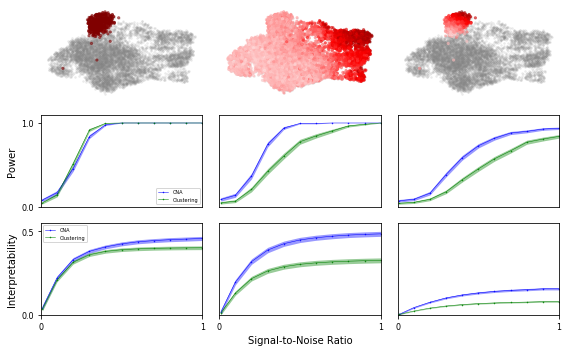

In [80]:
fig, axs = plt.subplots(3,3, figsize=(8,5))

for i, (simname, z, mask) in enumerate([
    ('clusterabundance/noise_{}/causalclust_leiden2', z_causalclust, mask),
    ('geneexpPCs/noise_{}', z_geneexpPCs, np.ones(len(d)).astype(bool)),
    ('clusterspecificPC1/noise_{}/causalclust_leiden1', z_clusterspecificPC1, mask),
    ]):
    print(simname)
    umap(z, mask, axs[0,i])
    df = read(simname)
    results = aggregate(df)
    power, interp = calculate(results)
    powerplot_mascbest(power, axs[1,i], ylabels=i==0, legend=i==0)
    interpplot_mascbest(interp, axs[2, i], xlabel=i==1, ylabels=i==0, legend=i==0)
plt.tight_layout()
plt.savefig('best_masc_resolution.pdf')

clusterabundance/noise_{}/causalclust_leiden2
geneexpPCs/noise_{}
clusterspecificPC1/noise_{}/causalclust_leiden1


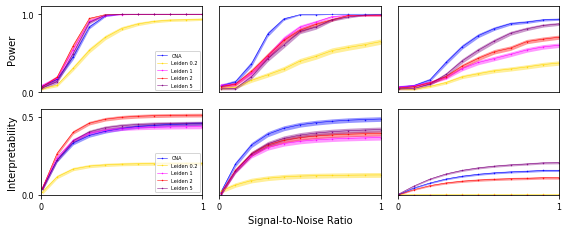

In [179]:
fig, axs = plt.subplots(2,3, figsize=(8,(5/3)*2))

for i, simname in enumerate([
    'clusterabundance/noise_{}/causalclust_leiden2',
    'geneexpPCs/noise_{}',
#     'clusterspecificPC1/noise_{}/causalclust_leiden0p2',
    'clusterspecificPC1/noise_{}/causalclust_leiden1',
#     'clusterspecificPC1/noise_{}/causalclust_leiden2',
    ]):
    print(simname)
    df = read(simname)
    results = aggregate(df)
    power, interp = calculate(results)
    powerplot_allmasc(power, axs[0,i], ylabels=i==0, legend=i==0)
    interpplot_allmasc(interp, axs[1, i], xlabel=i==1, ylabels=i==0, legend=i==0)
plt.tight_layout()
plt.savefig('all_masc_resolutions.pdf')